# SVM

Основная идея SVM состоит в том, чтобы провести разделительную линию так, чтобы границы решения были как можно шире, а сама линия находилась максимально далеко от двух ближайших образцов классов.

## Классификация с широким (жестким) зазором

Если SVM пытается построить наиболее возможную широкую полосу границ решения, то такая классификация с SVM называется **классификацией с широким (жестким) зазором**. 

In [1]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()
X = iris['data'][:, (0, 1)]
y = iris['target']

После загрузки датасета выберем первые два класса из 3-х, чтобы показывать примеры на бинарной классификации. Конечно же, на мультиклассовой классификации всё то же самое, просто обучается SVM по стратегии OvO.

In [3]:
X = X[(iris['target'] == 0) | (iris['target'] == 1)]
y = y[(iris['target'] == 0) | (iris['target'] == 1)]

Создадим SVM классификатор, при этом укажем `C` (параметр регуляризации) максимально возможным. Тем самым мы добьемся классификации с широким зазором.

In [4]:
svm = SVC(kernel='linear', C=float(np.inf))
svm.fit(X, y)

SVC(C=inf, kernel='linear')

In [5]:
def plot_svm(svm, X, y, xmin, xmax, ymin, ymax, save=None):
    # Рисуем точки
    plt.figure(figsize=(15, 10))
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=300, facecolors='yellow')
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], s=50, c='blue', marker='s')
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], s=50, c='red', marker='^')

    # Рисуем границу решений и две линии зазора
    # w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    w = svm.coef_[0]
    b = svm.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    boundary = -w[0]/w[1] * x0 - b/w[1]

    plt.plot(x0, boundary, 'k-', linewidth=2)
    plt.plot(x0, boundary + 1/w[1], 'g--', linewidth=1)
    plt.plot(x0, boundary - 1/w[1], 'g--', linewidth=1)

    # Настройки графика
    plt.xlabel('Длина чашечки', fontsize=24, labelpad=30)
    plt.ylabel('Ширина чашечки', fontsize=24, labelpad=30)
    ax = plt.gca()
    ax.tick_params(labelsize=22)
    plt.axis([xmin, xmax, ymin, ymax])
    if save:
        plt.savefig(save, dpi=200)
    plt.show()

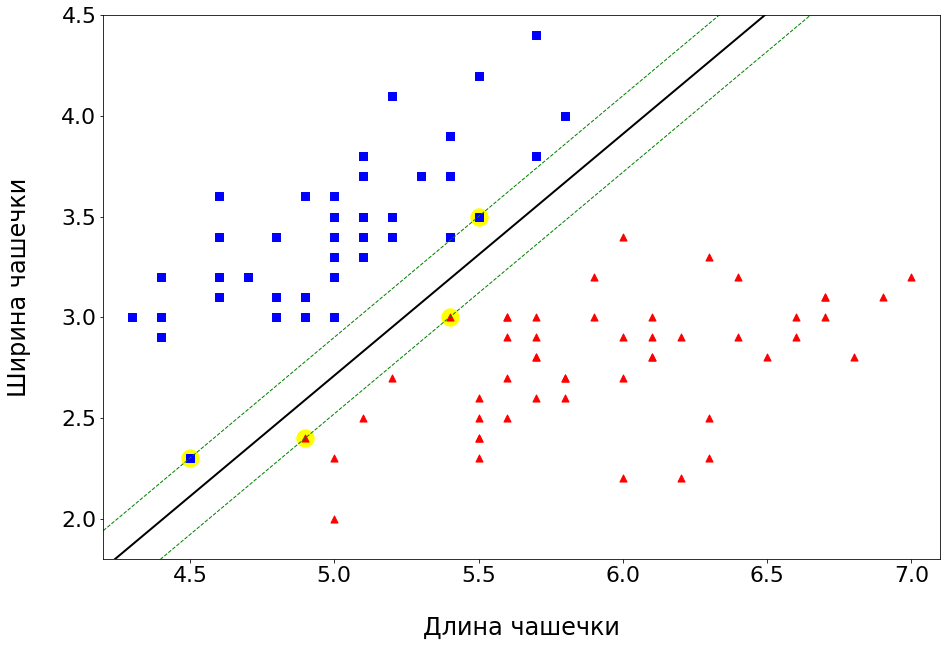

In [6]:
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5], save='hard_margin.png')

На графике желтым отмечены **опорные вектора**. Полоса решений SVM полностью определяются крайними образцами, лежащими на её границах. Такие образцы как раз и называются опорными векторами. Добавление новых образцов за этой полосой никак не повлияет на неё саму. Однако добавление новых образцов внутрь полосы изменит её, т.к. новые образцы станут новыми опорными векторами. 

## Чувствительность к масштабу

Важно отметить, что SVM **чувствительны** к масштабу признаков!

In [7]:
X = np.array([[1, 50], [5, 20], [3, 80], [5, 60]])
y = np.array([0, 0, 1, 1])

In [8]:
svm = SVC(kernel='linear', C=np.inf)
svm.fit(X, y)

SVC(C=inf, kernel='linear')

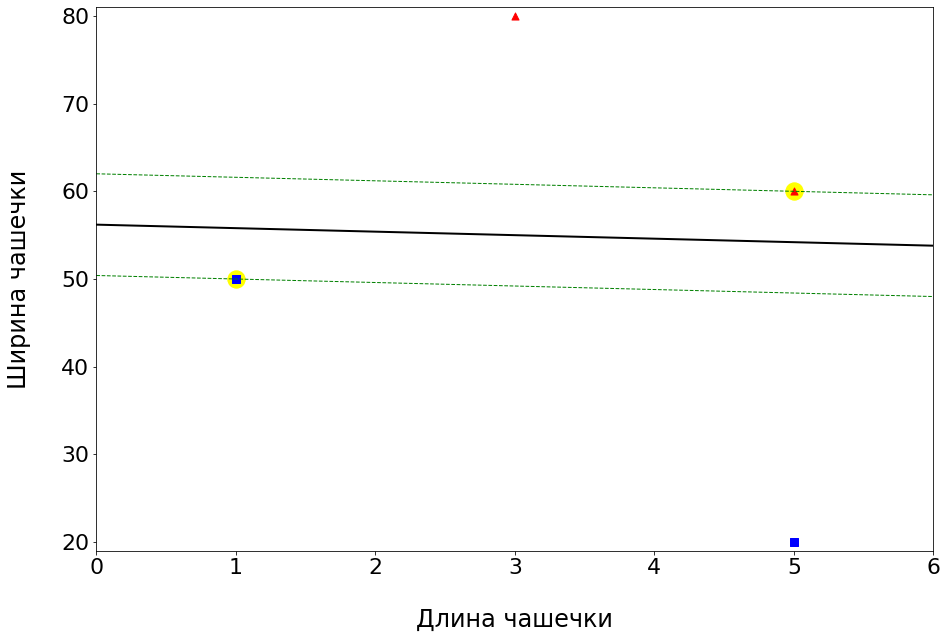

In [9]:
plot_svm(svm, X, y, 
         X[:, 0].min()-1, X[:, 0].max()+1, 
         X[:, 1].min()-1, X[:, 1].max()+1)

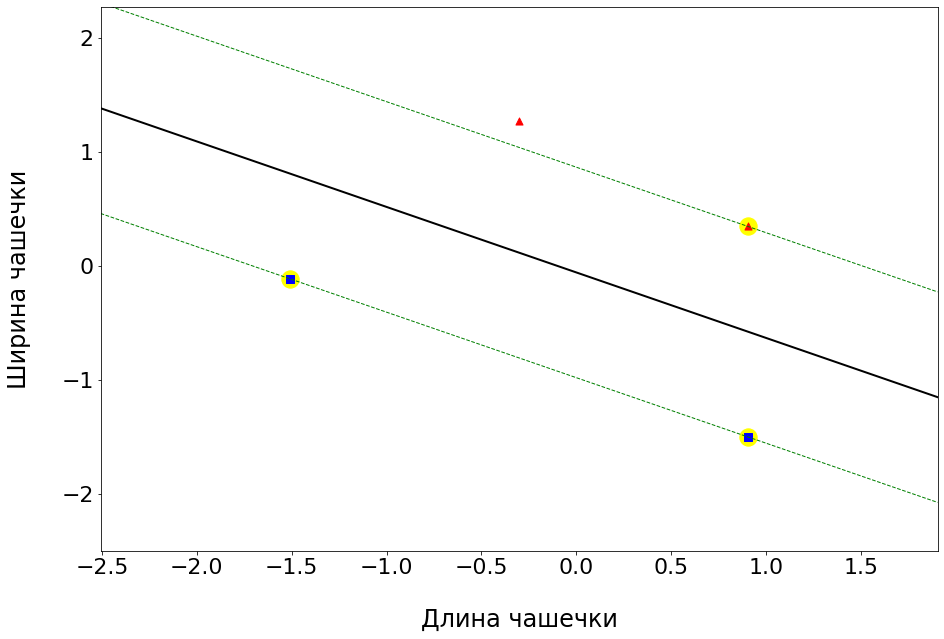

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm.fit(X_scaled, y)

plot_svm(svm, X_scaled, y, 
         X_scaled[:, 0].min()-1, X_scaled[:, 0].max()+1, 
         X_scaled[:, 1].min()-1, X_scaled[:, 1].max()+1)

На двух картинках мы можем увидеть значительную разницу в масштабах и то, как SVM под эти масштабы подстраивается. Вполне логично, что во втором случае граница выглядит куда разумнее, чем в первом.

## Чувствительность к выбросам

In [11]:
X = iris['data'][:, (0, 1)]
y = iris['target']

X = X[(iris['target'] == 0) | (iris['target'] == 1)]
y = y[(iris['target'] == 0) | (iris['target'] == 1)]

X_outliers = np.concatenate([X, [[5.5, 3.3]]], axis=0)
y_outliers = np.concatenate([y, [1]], axis=0)

In [12]:
svm_outlier = SVC(kernel='linear', C=float(np.inf))
svm_outlier.fit(X_outliers, y_outliers)

SVC(C=inf, kernel='linear')

In [13]:
svm = SVC(kernel='linear', C=float(np.inf))
svm.fit(X, y)

SVC(C=inf, kernel='linear')

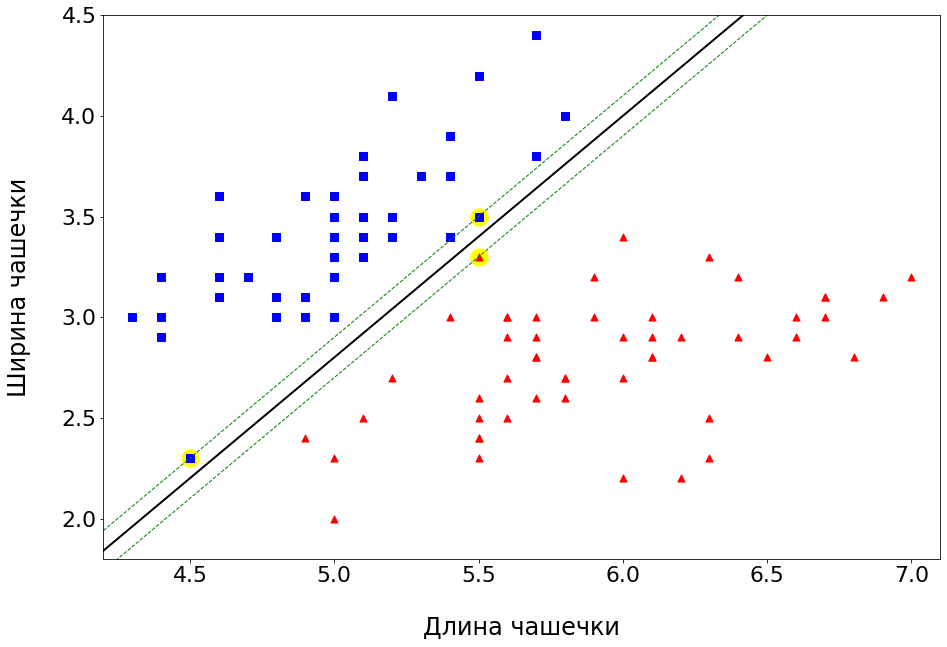

In [14]:
plot_svm(svm_outlier, X_outliers, y_outliers, *[4.2, 7.1, 1.8, 4.5])

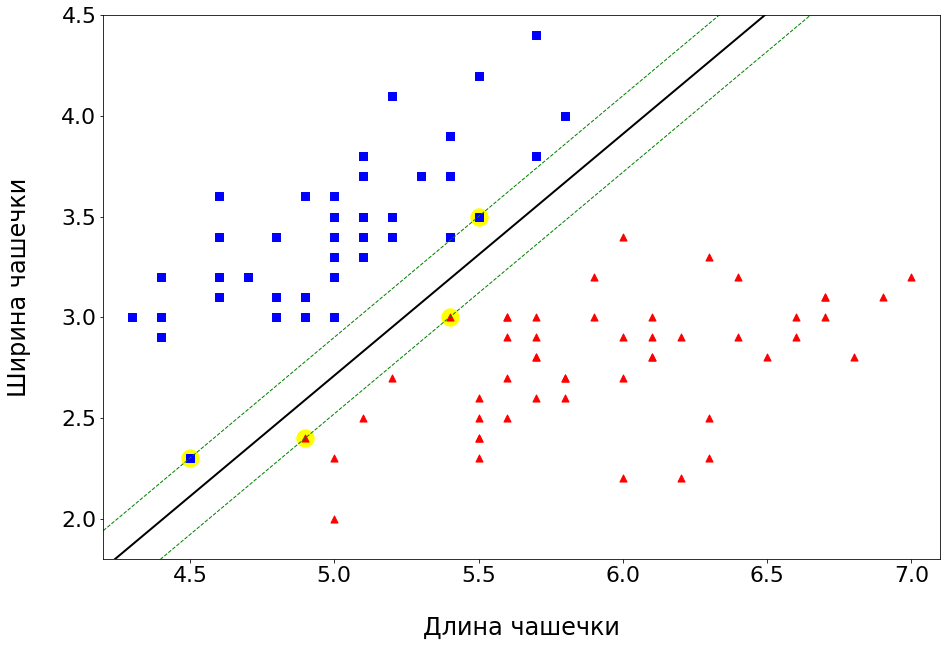

In [15]:
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

На предыдущих картинках разница более, чем очевидна.

## Классификация с мягким зазором

Чтобы избежать подобных проблем, можно использовать более гибкую модель. Цель обучения такой модели будет состоять в нахождении хорошего баланса между тем, чтобы держать зазор на сколько возможно широким, и тем, чтобы сократить нарушение зазора. Такая классификация называется **классификацией с мягким зазором**.

Чем меньше С, тем более мягким будет зазор. И наоборот. Всегда нужно искать компромисс в том, какое С выставлять. Иметь большое количество нарушений зазора всегда плохо. Однако, в некоторых случаях такие модели будут обобщаться гораздо лучше более регуляризованных моделей.

Посмотрим как будет выглядить классификатор при `C=1`.

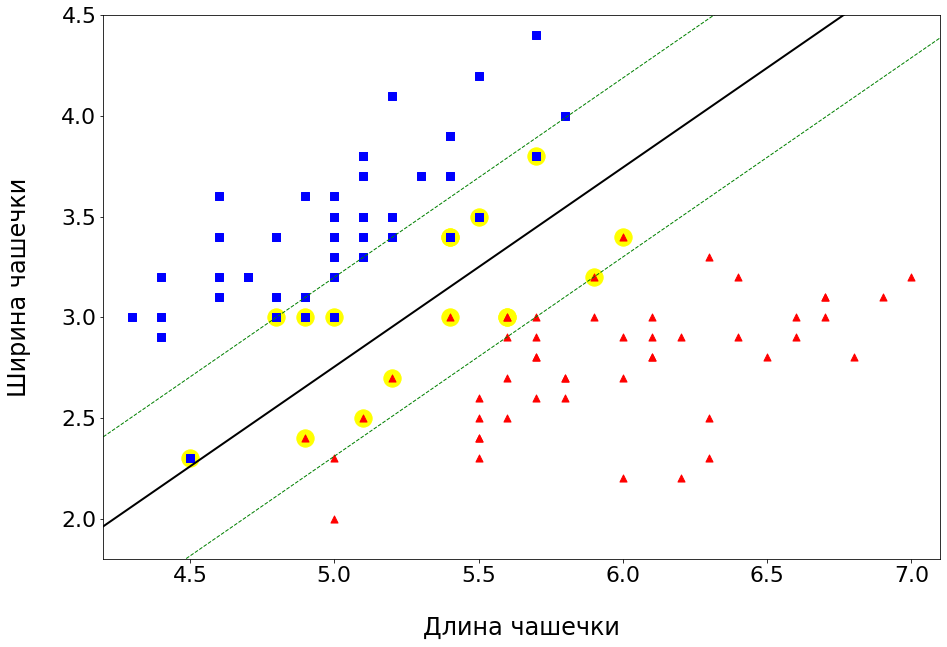

In [16]:
svm = SVC(kernel='linear', C=1)
svm.fit(X, y)
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

А теперь при `C=100`.

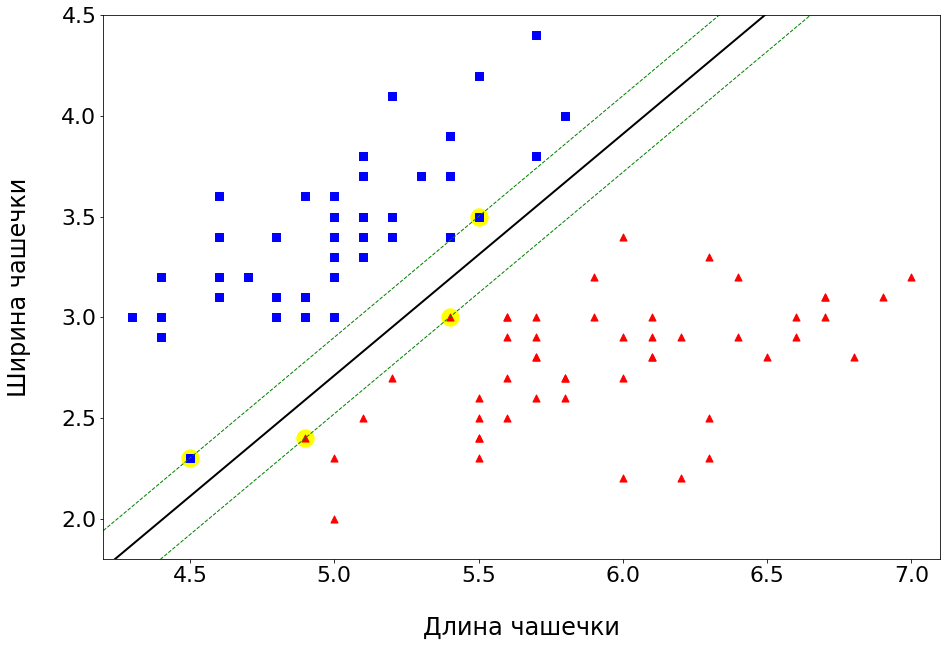

In [17]:
svm = SVC(kernel='linear', C=100)
svm.fit(X, y)
plot_svm(svm, X, y, *[4.2, 7.1, 1.8, 4.5])

# Нелинейная классификация

## Полиномиальные признаки

Многие датасеты могут быть линейно не сепарабельны и это нормально. Чтобы SVM мог обобщаться на нелинейные данные, существует несколько способов. Один подход заключается в добавлении нескольких признаков, как полиномиальные.

In [18]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

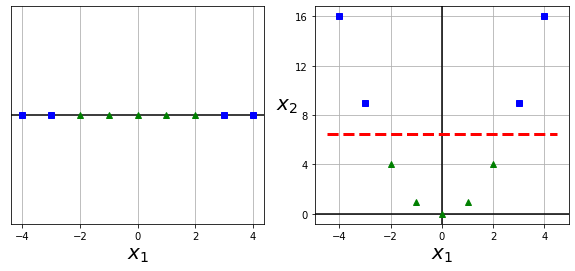

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)

plt.show()

Создадим и оценим Pipeline на датасете moons (чередующиеся полукольца).

In [20]:
from sklearn.datasets import make_moons

In [32]:
X, y = make_moons(n_samples=100, noise=0.2)

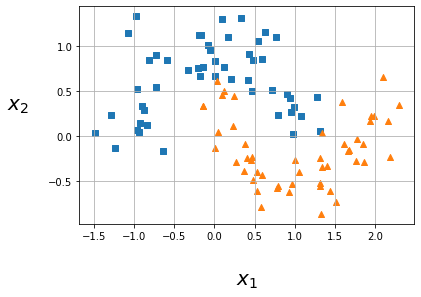

In [37]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker='s')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker='^')
plt.xlabel('$x_1$', fontsize=20, labelpad=30)
plt.ylabel('$x_2$', fontsize=20, rotation=0, labelpad=30)
plt.grid()
plt.show()

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

svm_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1))
])
svm_pipeline.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm', SVC(C=1, kernel='linear'))])

In [78]:
def plot_poly_svm(svm, X, y, xmin, xmax, ymin, ymax):
    # Чертим контур
    x0, x1 = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))
    Xs = np.c_[x0.ravel(), x1.ravel()]
    y_pred = svm.predict(Xs).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, alpha=0.2, cmap=plt.cm.brg)
    
    # Рисуем сам датасет
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker='s')
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker='^')
    plt.xlabel('$x_1$', fontsize=20, labelpad=30)
    plt.ylabel('$x_2$', fontsize=20, rotation=0, labelpad=30)
    plt.grid()

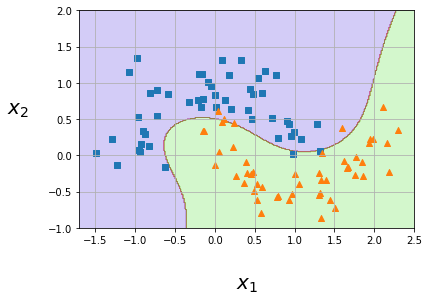

In [79]:
plot_poly_svm(svm_pipeline, X, y, *[-1.7, 2.5, -1, 2])

Выберем любые две точки, чтобы проверить корректность нашего классификатора.

In [80]:
svm_pipeline.predict([[0.5, -0.5]]), svm_pipeline.predict([[0, 1]])

(array([1]), array([0]))

Воспользуемся классом LinearSVC, выполняющая ту же работу, что и класс SVC. Просто убедимся, что в пакете `svm` уже имеются необходимые классы под конкретную задачу.

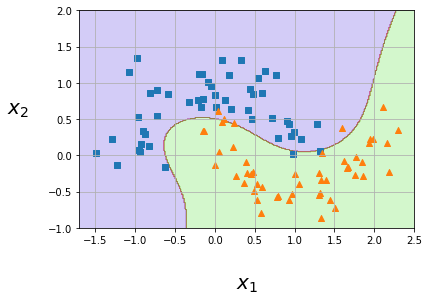

In [81]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(C=1))
])
svm_pipeline.fit(X,y)

plot_poly_svm(svm_pipeline, X, y, *[-1.7, 2.5, -1, 2])

## Полиномиальное ядро

В SVM существует практически магическая математическая техника, способная решить большое количество проблем. Такая техника называется **ядерный трюк**. К примеру, полиномиальное ядро (одно из множества ядер в SVM) позволяет получить сходный с PolynomialFeatures результат, не добавляя степенных признаков вообще. Поэтому, не возникает никакого лишнего замедления и "взрыва" степенной функции, потому что на самом деле никаких признаков вы не добавляете.

До этого мы использовали функционал `PolynomialFeatures`, чтобы задать дополнительные степени для нашего датасета. Теперь посмотрим на возможность **ядерных операций** с SVM: зададим **полиномиальное ядро** в классе `SVC` и посмотрим на результат.

Любые ядерные трюки реализуются с помощью класса **SVC(kernel=...)**, где в kernel записывается необходимое ядро.

In [108]:
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=3, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, coef0=1, kernel='poly'))])

В классе `SVC` при использовании `kernel='poly'` появляется возможность задать гиперпараметр `coef0`, который контролирует, насколько модель будет сильно зависеть от полиномов высокой степени, чем от полиномов низкой степени.

Посмотрим, как изменяется модель при изменении `coef0` для степени полинома 10.

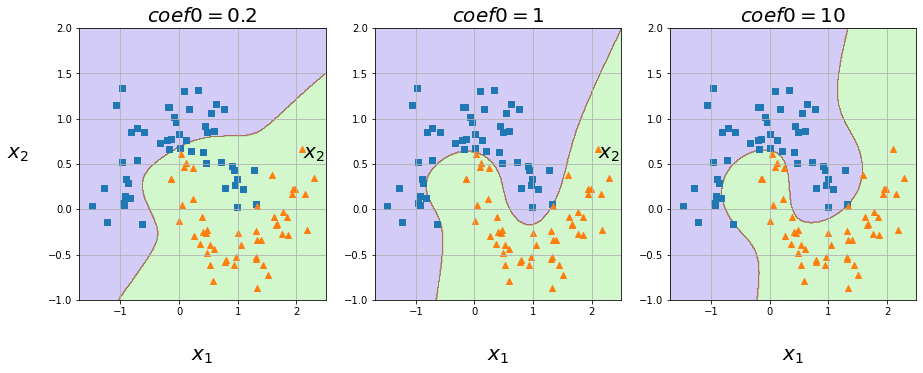

In [121]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=0.2, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=0.2$', fontsize=20)

plt.subplot(132)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=1$', fontsize=20)

plt.subplot(133)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=10, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$coef0=10$', fontsize=20)

plt.savefig('coef0_svm.png', dpi=300)
plt.show()

Теперь посмотрим на изменение степени `degree` при `coef0=1`.

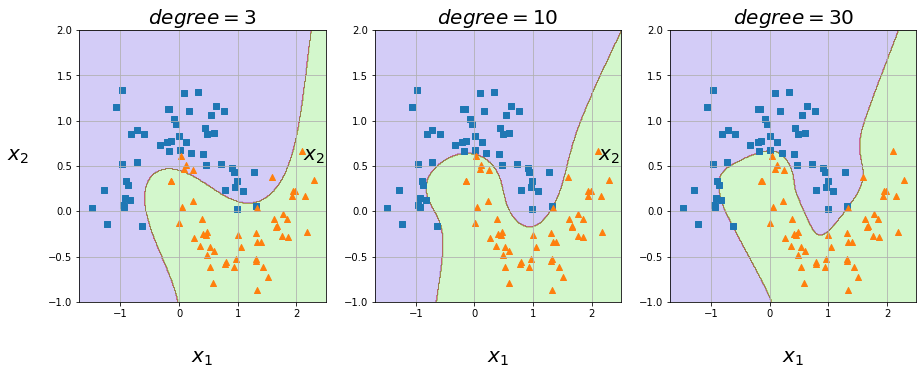

In [122]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=3, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=3$', fontsize=20)

plt.subplot(132)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=10, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=10$', fontsize=20)

plt.subplot(133)
svm_polykernel_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='poly', degree=30, coef0=1, C=1))
])
svm_polykernel_pipeline.fit(X, y)
plot_poly_svm(svm_polykernel_pipeline, X, y, *[-1.7, 2.5, -1, 2])
plt.title('$degree=30$', fontsize=20)

plt.savefig('degree_svm.png', dpi=300)
plt.show()

## Признаки сходства

Ещё одной техникой для решения проблемы нелинейности данных является добавление новых признаков, вычесленных с использованием **функции сходства**, которая измеряет насколько каждый образец схож с конкретным ориентиром.

Давайте определим функцию сходства как **функцию радиального базиса Гаусса (Gaussian Radial Basis Function - RBF)** с $\gamma=0.3$.

$$\phi_\gamma(x, l) = \exp(-\gamma\|x-l\|^2)$$

In [139]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

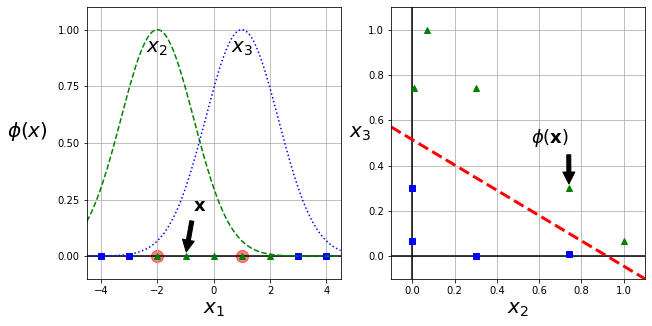

In [135]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

# Измеряем функцию RBF для значений на оси
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 5))

# Параметры графика: сетка и отрисовка оси
plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')

# Чертим красные круги для обозначения 
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$\phi(x)$", fontsize=20, rotation=0, labelpad=30)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.show()

RBF изменяется от 0 (очень далеко от ориентира) до 1 (сам ориентир) - она измеряет расстояние до ориентира.